In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

In [4]:
import scipy.stats as stats

## 1. Create the dataset

In [5]:
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack( (  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                         1+np.ones( (nPerClust))  ) )

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# note: "long" format for CCE :Multiclass classification
labels = torch.tensor(labels_np).long()    

## 2. Data Visualization

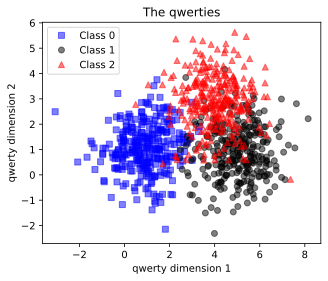

In [6]:
# show the data
fig = plt.figure(figsize=(5,4) ,dpi = 140)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',
         alpha=.5 , label = "Class 0")
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',
         alpha=.5 ,label = "Class 1")
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',
         alpha=.5 ,label = "Class 2")

plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.legend()
plt.show()

## 3. Convert the Data into Tensor Dataset

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [8]:
# scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects

batchsize    = 16 
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True  ,drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0] ) 

## 4. Create and validate the model

In [9]:
# create a class for the model
def createQwertyNet_Optimizer(LR ,optimizerAlgo):

    class qwertyNet(nn.Module):
        
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2,8)

            ### hidden layer
            self.fc1 = nn.Linear(8,8)

            ### output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Hidden Layer
            x = F.relu( self.fc1(x) )
            
            return self.output(x)

    # create the model instance
    ANN_model = qwertyNet()

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optifunc = getattr( torch.optim,optimizerAlgo )
    optimizer = optifunc(ANN_model.parameters(),lr=LR)
    
    
    return ANN_model,lossfunc,optimizer

In [10]:
# test the model with fake input

test_model , lf , opt = createQwertyNet_Optimizer(LR = 0.01 , optimizerAlgo = "Adam")
print(opt)

# input is ten samples
testinput = torch.rand(10,2)
test_model(testinput)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


tensor([[-0.1442,  0.0282, -0.3853],
        [-0.1691, -0.0239, -0.3040],
        [-0.1526,  0.0268, -0.3755],
        [-0.1412,  0.0416, -0.4055],
        [-0.1444,  0.0351, -0.3925],
        [-0.1427,  0.0288, -0.3909],
        [-0.1502,  0.0156, -0.3647],
        [-0.1602,  0.0080, -0.3475],
        [-0.1782,  0.0019, -0.3365],
        [-0.1734,  0.0087, -0.3441]], grad_fn=<AddmmBackward0>)

## 5. Model Training

In [11]:
def function2trainTheModel(Model , lossfunc , optimizer ,train_loader , test_loader , epochs):

    # initialize losses
    losses   = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
         # Batch Training
        for X,y in train_loader:

            # forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat_train,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
      
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round(100*torch.mean((torch.argmax(yHat_test,axis=1)==y).float()),2 ) )
        # end epochs

    # function output
    return trainAcc,testAcc,losses,Model


## 6.  Function For Plotting Results

#### Function to Plot the Results on Test Data and complete data

In [12]:

def plotTheResults(optimizerType,Model_trained ,data , labels ,losses ,trainAcc,testAcc  , FigSize  ):

    # Compute accuracy over entire dataset (train+test)
    yHat = Model_trained(data)  # Trained Model
    
    predictions = torch.argmax(yHat,axis=1)
    accuracy    = (predictions == labels).float()
    totalAcc    = torch.mean(100*accuracy).item()

    # Accuracy by group
    accuracyByGroup = np.zeros(3)
    
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


    # Create the figure
    fig,ax = plt.subplots(2,2,figsize=FigSize)

    # Plot the loss function
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_title(f'{optimizerType}: Losses')

    # Plot the Accuracy : Train and Test
    ax[0,1].plot(trainAcc,label='Train')
    ax[0,1].plot(testAcc,label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f'{optimizerType}: Accuracy')
    ax[0,1].legend()

    # Plot overall Accuracy by group
    ax[1,0].bar(range(3),accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
    
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title(f'{optimizerType}: Accuracy by group')

    # Scatterplot of correct and incorrect labeled data
    # data markers
    colorShapes = [ 'bs','ko','g^' ] 
    
    for i in range(3):
        
        # Plot all data points
        ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
                     alpha=.3, label=f'Group {i}')

        # cross-out the incorrect ones
        idxErr = (accuracy==0) & (labels==i)
        ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')

    ax[1,1].set_title(f'{optimizerType}: Total accuracy: {totalAcc:.2f}%')
    ax[1,1].set_xlabel('qwerty dimension 1')
    ax[1,1].set_ylabel('qwerty dimension 2')
    ax[1,1].legend()

    plt.tight_layout()
    
    plt.show()

#### Function to Plot the Results on Test Data

In [ ]:
def plotTheResults2(optimizerType,Model_trained ,data , labels ,losses ,trainAcc,testAcc  ,
                    test_loader , FigSize  ):
    
    # test accuracy
    Model_trained.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    
    with torch.no_grad():         # deactivates autograd
        yHat_test = Model_trained(X)
   
    # yHat = Model_trained(data)  # Trained Model
    
    predictions = torch.argmax(yHat_test,axis=1)
    accuracy    = (predictions == y).float()
    totalAcc    = torch.mean(100*accuracy).item()

    # Accuracy by group
    accuracyByGroup = np.zeros(3)
    
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[y==i])


    # Create the figure
    fig,ax = plt.subplots(2,2,figsize=FigSize)

    # Plot the loss function
    ax[0,0].plot(losses.detach())
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_title(f'{optimizerType}: Losses')

    # Plot the accuracy functions
    ax[0,1].plot(trainAcc,label='Train')
    ax[0,1].plot(testAcc,label='Test')
    ax[0,1].set_ylabel('Accuracy (%)')
    ax[0,1].set_xlabel('Epoch')
    ax[0,1].set_title(f'{optimizerType}: Accuracy')
    ax[0,1].legend()

    # Plot overall accuracy by group
    ax[1,0].bar(range(3),accuracyByGroup)
    ax[1,0].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
    
    ax[1,0].set_xticks([0,1,2])
    ax[1,0].set_xlabel('Group')
    ax[1,0].set_ylabel('Accuracy (%)')
    ax[1,0].set_title(f'{optimizerType}: Accuracy by group on Test Data')

    # Scatterplot of correct and incorrect labeled data
    # data markers
    colorShapes = [ 'bs','ko','g^' ] 
    
    for i in range(3):
        
        # Plot all data points
        #ax[1,1].plot(data[labels==i,0],data[labels==i,1],colorShapes[i],
        #             alpha=.3, label=f'Group {i}')
        
        ax[1,1].plot(X[y==i,0],X[y==i,1],colorShapes[i],
                     alpha=.3, label=f'Group {i}')

        # cross-out the incorrect ones
        #idxErr = (accuracy==0) & (labels==i)
        idxErr = (accuracy==0) & (y==i)
        
        #ax[1,1].plot(data[idxErr,0],data[idxErr,1],'rx')
        ax[1,1].plot(X[idxErr,0],X[idxErr,1],'rx')
        
    ax[1,1].set_title(f'{optimizerType}: Test accuracy Visualization: {totalAcc:.2f}%')
    ax[1,1].set_xlabel('qwerty dimension 1')
    ax[1,1].set_ylabel('qwerty dimension 2')
    ax[1,1].legend()

    plt.tight_layout()
    
    plt.show()

## 7. Experiment

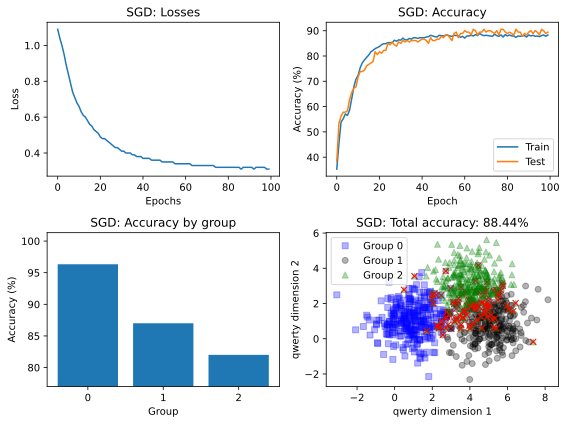

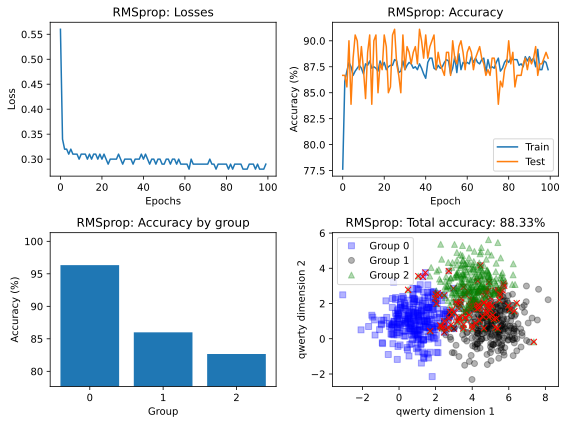

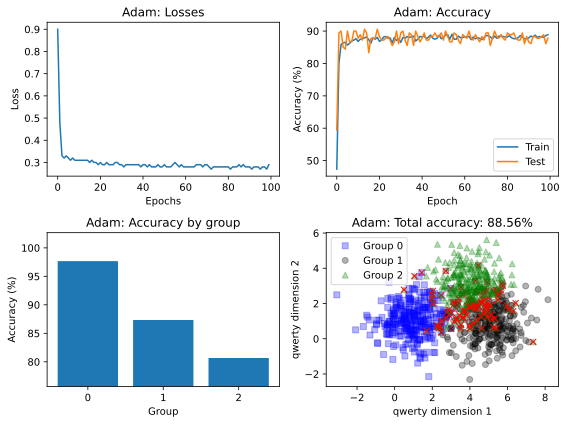

In [13]:
LR = 0.01
num_epochs = 100
optimizers_list = ['SGD' , 'RMSprop' , 'Adam']
performance = []

for Opti in optimizers_list :
    
    ANN_model,lossfunc,optimizer = createQwertyNet_Optimizer(LR = LR ,optimizerAlgo = Opti)

    TrainAcc,TestAcc,Losses,trained_Model = function2trainTheModel(Model = ANN_model ,
                                                                   lossfunc = lossfunc , 
                                                                   optimizer = optimizer,
                                                                   train_loader = train_loader , 
                                                                   test_loader  = test_loader, 
                                                                   epochs = num_epochs )
    
    
    plotTheResults(optimizerType = Opti,
                   Model_trained = trained_Model ,
                   data = data ,labels  = labels, 
                   losses = Losses ,trainAcc = TrainAcc,testAcc = TestAcc,
                   FigSize = (8,6))
    
    # Store the final results
    train = np.mean(TrainAcc[-10:])
    test  = np.mean(TestAcc[-10:])

    performance.append( f'{Opti}: train {train:.1f}%, test {test:.1f}%' )

In [14]:
performance

['SGD: train 88.0%, test 89.5%',
 'RMSprop: train 87.9%, test 88.2%',
 'Adam: train 88.3%, test 87.6%']

In [17]:
X ,y = next(iter(test_loader))

In [18]:
X

tensor([[ 4.5621,  3.8352],
        [ 0.1631,  1.7706],
        [ 4.2635,  2.9624],
        [ 3.8428,  5.1507],
        [ 2.5123,  2.9413],
        [ 6.2886,  0.5649],
        [ 2.5338,  1.4054],
        [ 1.7003,  1.7117],
        [ 2.6620,  0.9192],
        [ 3.2766, -1.0082],
        [ 2.2606,  0.7635],
        [ 5.7077,  3.1306],
        [ 5.7476, -0.9298],
        [ 2.7759,  3.0078],
        [ 1.4454,  0.6478],
        [ 4.3252,  2.7129],
        [ 1.5486,  0.9615],
        [ 5.1468,  0.6127],
        [ 4.2716,  0.3172],
        [ 0.4961,  2.7807],
        [ 4.4712,  1.3731],
        [ 2.0597,  1.2146],
        [ 0.3007,  0.8832],
        [ 5.1563,  2.6670],
        [ 2.7404,  3.3238],
        [ 3.5450,  1.0813],
        [ 0.6380,  0.7524],
        [ 2.6452,  2.9657],
        [ 0.8347,  2.2820],
        [ 3.1166, -0.3690],
        [ 5.0007,  0.5929],
        [ 3.1432,  2.7462],
        [ 2.2228,  1.1942],
        [ 5.1892,  1.2288],
        [ 4.5357,  3.1241],
        [ 3.8068,  1

In [19]:
y

tensor([2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2,
        2, 1, 0, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 0, 2, 1,
        1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 2, 0, 1,
        1, 2, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1,
        1, 2, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 2, 0, 0,
        2, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1,
        1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 0, 1, 1, 2,
        0, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0])

#### On test Data only

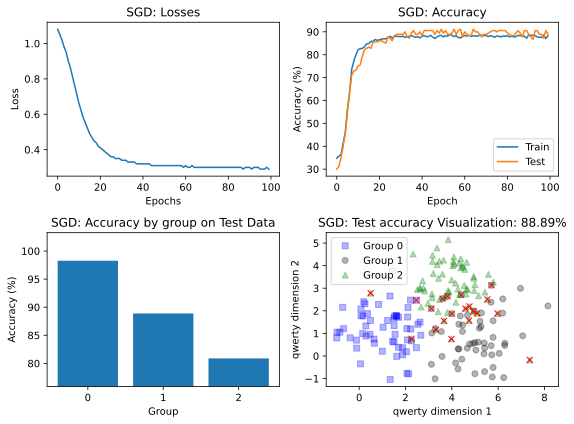

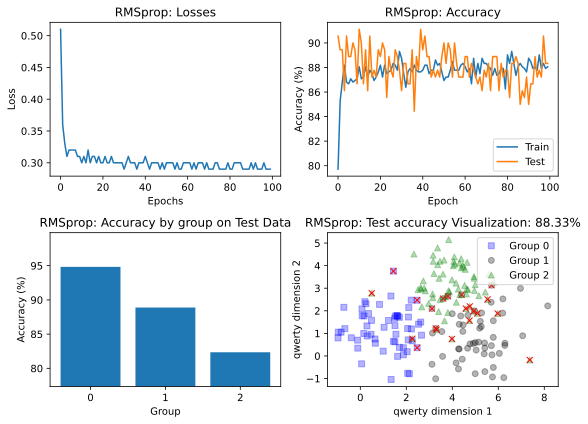

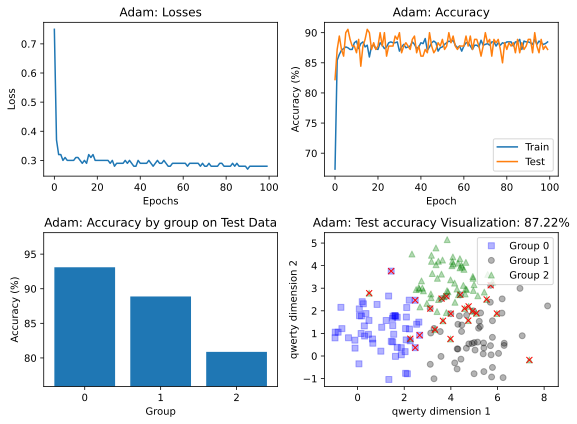

In [33]:
LR = 0.01
num_epochs = 100
optimizers_list = ['SGD' , 'RMSprop' , 'Adam']
performance = []

for Opti in optimizers_list :
    
    ANN_model,lossfunc,optimizer = createQwertyNet_Optimizer(LR = LR ,optimizerAlgo = Opti)

    TrainAcc,TestAcc,Losses,trained_Model = function2trainTheModel(Model = ANN_model ,
                                                                   lossfunc = lossfunc , 
                                                                   optimizer = optimizer,
                                                                   train_loader = train_loader , 
                                                                   test_loader  = test_loader, 
                                                                   epochs = num_epochs )
    
    
    plotTheResults2(optimizerType = Opti,
                   Model_trained = trained_Model ,
                   data = data ,labels  = labels, 
                   losses = Losses ,trainAcc = TrainAcc,testAcc = TestAcc,
                   test_loader = test_loader,
                   FigSize = (8,6))
    
    # Store the final results
    train = np.mean(TrainAcc[-10:])
    test  = np.mean(TestAcc[-10:])

    performance.append( f'{Opti}: train {train:.1f}%, test {test:.1f}%' )